$$\text{\Huge{Pancreatic Cancer}}$$
**Dataset:** [Kaggle](https://www.kaggle.com/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer?select=Debernardi+et+al+2020+documentation.csv)

**Open-access Paper:** [PLOS Medicine](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489)

$$\text{\Huge{Setup}}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import scienceplots
import seaborn as sns
import sklearn as sk

from abc import ABC
from IPython.display import display, HTML
from matplotlib.ticker import FixedLocator
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFECV
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from typing_extensions import Self
from xgboost import XGBClassifier, XGBRegressor

In [2]:
plt.style.use('science')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlepad'] = 15 
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['legend.title_fontsize'] = 16
plt.rcParams['legend.fontsize'] = 12

In [3]:
CASES = {
    'ca19 9': 'CA19-9',
    'lyve1': 'LYVE1',
    'reg1b': 'REG1B',
    'tff1': 'TFF1',
    'reg1a': 'REG1A',
    'creatinine': 'Creatinine',
    'max': 'Maximum',
    'min': 'Minimum',
    'sex M': 'Sex (M)',
    'sex F': 'Sex (F)',
    'param': ''
}

def column_to_title(column: str) ->  str:
    column = str(column).replace('_', ' ').title()

    for word, replacement in CASES.items():
        column = column.replace(word.title(), replacement)

    return column

In [4]:
def update_label(labels: list[str]) -> list[str]:
    y = []
    
    for label in labels:
        text = label.get_text()
        label = column_to_title(text)
        
        y.append(label)

    return y

In [5]:
def display_correlation(dataset: pd.DataFrame) -> None:
    dataset = dataset.apply(pd.to_numeric, errors='coerce')
    dataset = dataset.dropna(axis=1, how='all')
    
    figsize = (12, 12)
    fig, ax = plt.subplots(figsize=figsize)

    correlation = dataset.corr()

    heatmap = sns.heatmap(
        correlation,
        annot=True,
        annot_kws={'size': 16},
        cmap='Blues',
        fmt='.2f',
        square=True
    )

    x = [x.get_text() for x in ax.get_xticklabels()]
    y = [y.get_text() for y in ax.get_yticklabels()]

    x = map(column_to_title, x)
    y = map(column_to_title, y)

    ax.tick_params(axis='both', which='both', length=0)

    ax.set_xticklabels(x)
    ax.set_yticklabels(y)

    plt.tight_layout()
    plt.show()
    plt.close()
    

def display_confusion_matrix(
    title: str, 
    test: npt.NDArray, 
    prediction: npt.NDArray
) -> None:
    figsize = (8, 8)
    fig, ax = plt.subplots(figsize=figsize)

    cm = confusion_matrix(test, prediction)

    heatmap = sns.heatmap(
        cm, 
        annot=True,
        annot_kws={'size': 16},
        square=True, 
        fmt='.0f'
    )
    
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    
    ax.tick_params(axis='both', which='both', length=0)

    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(length=0)  

    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()
    plt.close()


def display_permutation_importance(data: pd.DataFrame, name: str | None = None) -> None:
    figsize = (16, 4)
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.barplot(
        data=data,
        y='variable',
        x='importance',
        hue='variable',
        palette='hls',
        legend=False
    )
    
    ax.tick_params(axis='y', which='both', left=False, right=False)
    
    ax.set_xlabel('Importance')
    ax.set_ylabel('Variable')
    
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    yticklabels = update_label(yticklabels)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    title = f"Permutation Importance for {name}"
    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def display_classification_score( 
    test: npt.NDArray, 
    prediction: npt.NDArray,
    **kwargs
) -> pd.DataFrame:        
    score = {}

    accuracy = accuracy_score(
        test,
        prediction
    )

    precision = precision_score(
        test,
        prediction,
        **kwargs
    )

    recall = recall_score(
        test,
        prediction,
        **kwargs
    )

    f1 = f1_score(
        test,
        prediction,
        **kwargs
    )

    score['Accuracy'] = accuracy
    score['Precision'] = precision
    score['Recall'] = recall
    score['F1'] = f1

    data = score.items()
    columns = ['Metric', 'Score']

    return pd.DataFrame(data=data, columns=columns)


def display_null_score(dataset: pd.DataFrame) -> pd.DataFrame:   
        total = len(dataset)

        columns = [
            column for
            column in dataset.columns
            if dataset[column].isna().sum() > 0
        ]

        report = []

        for column in columns:
            score = {}

            present = dataset[column].notna().sum()
            missing = dataset[column].isna().sum()

            present_percentage = str(
                round(
                    (present / total) * 100,
                    2
                )
            )

            missing_percentage = str(
                round(
                    (missing / total) * 100,
                    2
                )
            )

            score['column'] = column
            score['present'] = present
            score['missing'] = missing
            score['total'] = total
            score['present_percentage'] = present_percentage
            score['missing_percentage'] = missing_percentage

            report.append(score)

        return pd.DataFrame(report)


def display_column_breakdown(dataframe: pd.DataFrame, column: str) -> pd.DataFrame:     
    report = []

    total = dataframe[column].notna().sum()
    count = dataframe[column].value_counts()

    for name, present in count.items():
        name = str(name)
        score = {}

        present_percentage = str(
            round(
                (present / total) * 100,
                2
            )
        )

        score['name'] = name
        score['present'] = present
        score['total'] = total
        score['present_percentage'] = present_percentage

        report.append(score)

    return pd.DataFrame(report)

In [7]:
class Biomarker:
    def __init__(self):
        self.name = None
        self.unit = None

    def __str__(self) -> str:
        return f"{self.name} ({self.unit})"

    def __repr__(self) -> str:
        return f"{self.name} ({self.unit})"

    @staticmethod
    def get_biomarker(name: str = 'plasma_CA19_9') -> Self:
        factory = {
            'plasma_CA19_9': PlasmaCA199,
            'creatinine': Creatinine,
            'LYVE1': LYVE1,
            'REG1B': REG1B,
            'TFF1': TFF1,
            'REG1A': REG1A
        }

        biomarker = factory.get(name)

        if biomarker is None:
            return None

        instance = biomarker()
        return str(instance)


class PlasmaCA199(Biomarker):
    def __init__(self):
        super().__init__()

        self.name = 'Plasma CA-19 9'
        self.unit = 'U/ml'


class Creatinine(Biomarker):
    def __init__(self):
        super().__init__()

        self.name = 'Creatinine'
        self.unit = 'mg/ml'


class LYVE1(Biomarker):
    def __init__(self):
        super().__init__()

        self.name = 'LYVE1'
        self.unit = 'ng/ml'


class REG1B(Biomarker):
    def __init__(self):
        super().__init__()

        self.name = 'REG1B'
        self.unit = 'ng/ml'


class TFF1(Biomarker):
    def __init__(self):
        super().__init__()

        self.name = 'REG1B'
        self.unit = 'ng/ml'


class REG1A(Biomarker):
    def __init__(self):
        super().__init__()

        self.name = 'REG1A'
        self.unit = 'ng/ml'

$$\text{\Huge{Data understanding}}$$

In [8]:
dtype = {
    'sample_id': 'object',
    'patient_cohort': 'category',
    'sample_origin': 'category',
    'age': 'int8',
    'sex': 'category',
    'diagnosis': 'category',
    'stage': 'category',
    'benign_sample_diagnosis': 'category',
    'plasma_CA19_9': 'float64',
    'creatinine': 'float64',
    'LYVE1': 'float64',
    'REG1B': 'float64',
    'TFF1': 'float64',
    'REG1A': 'float64'
}

usecols = [
    'sample_id',
    'patient_cohort',
    'sample_origin',
    'age',
    'sex',
    'diagnosis',
    'stage',
    'benign_sample_diagnosis',
    'plasma_CA19_9',
    'creatinine',
    'LYVE1',
    'REG1B',
    'TFF1',
    'REG1A'
]

df_cancer = pd.read_csv(
    'cancer.csv',
    engine='python',
    dtype=dtype,
    usecols=usecols
)

In [9]:
categorical = df_cancer.select_dtypes(['category', 'object']).columns.tolist()
categorical.sort()

numerical = df_cancer.select_dtypes('number').columns.tolist()
numerical.sort()

In [10]:
df_cancer.shape

(590, 14)

In [11]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   sample_id                590 non-null    object  
 1   patient_cohort           590 non-null    category
 2   sample_origin            590 non-null    category
 3   age                      590 non-null    int8    
 4   sex                      590 non-null    category
 5   diagnosis                590 non-null    category
 6   stage                    199 non-null    category
 7   benign_sample_diagnosis  208 non-null    category
 8   plasma_CA19_9            350 non-null    float64 
 9   creatinine               590 non-null    float64 
 10  LYVE1                    590 non-null    float64 
 11  REG1B                    590 non-null    float64 
 12  TFF1                     590 non-null    float64 
 13  REG1A                    306 non-null    float64 
dtypes: categor

In [12]:
df_cancer.head(5)

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [13]:
display_null_score(df_cancer)

,column,present,missing,total,present_percentage,missing_percentage
0,stage,199,391,590,33.73,66.27
1,benign_sample_diagnosis,208,382,590,35.25,64.75
2,plasma_CA19_9,350,240,590,59.32,40.68
3,REG1A,306,284,590,51.86,48.14


In [14]:
df_cancer.describe()

,age,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,59.079661,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,13.109520,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,26.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,60.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,89.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


Store the unique diagnoses and stages in variables, and print the count of each occurence.

In [15]:
diagnoses = df_cancer.benign_sample_diagnosis.dropna().unique()
display_column_breakdown(df_cancer, 'benign_sample_diagnosis')

,name,present,total,present_percentage
0,Pancreatitis,41,208,19.71
1,Pancreatitis (Chronic),35,208,16.83
2,Gallstones,21,208,10.1
3,Pancreatitis (Alcohol-Chronic),11,208,5.29
4,Cholecystitis,9,208,4.33
5,Serous cystadenoma - NOS,7,208,3.37
6,Abdominal Pain,6,208,2.88
7,Choledocholiathiasis,6,208,2.88
8,Pancreatitis (Alcohol-Chronic-Pseuodcyst),4,208,1.92
9,Pancreatitis (Idiopathic),4,208,1.92


In [16]:
stages = df_cancer.stage.dropna().unique()
display_column_breakdown(df_cancer, 'stage')

,name,present,total,present_percentage
0,III,76,199,38.19
1,IIB,68,199,34.17
2,IV,21,199,10.55
3,IB,12,199,6.03
4,IIA,11,199,5.53
5,II,7,199,3.52
6,IA,3,199,1.51
7,I,1,199,0.5


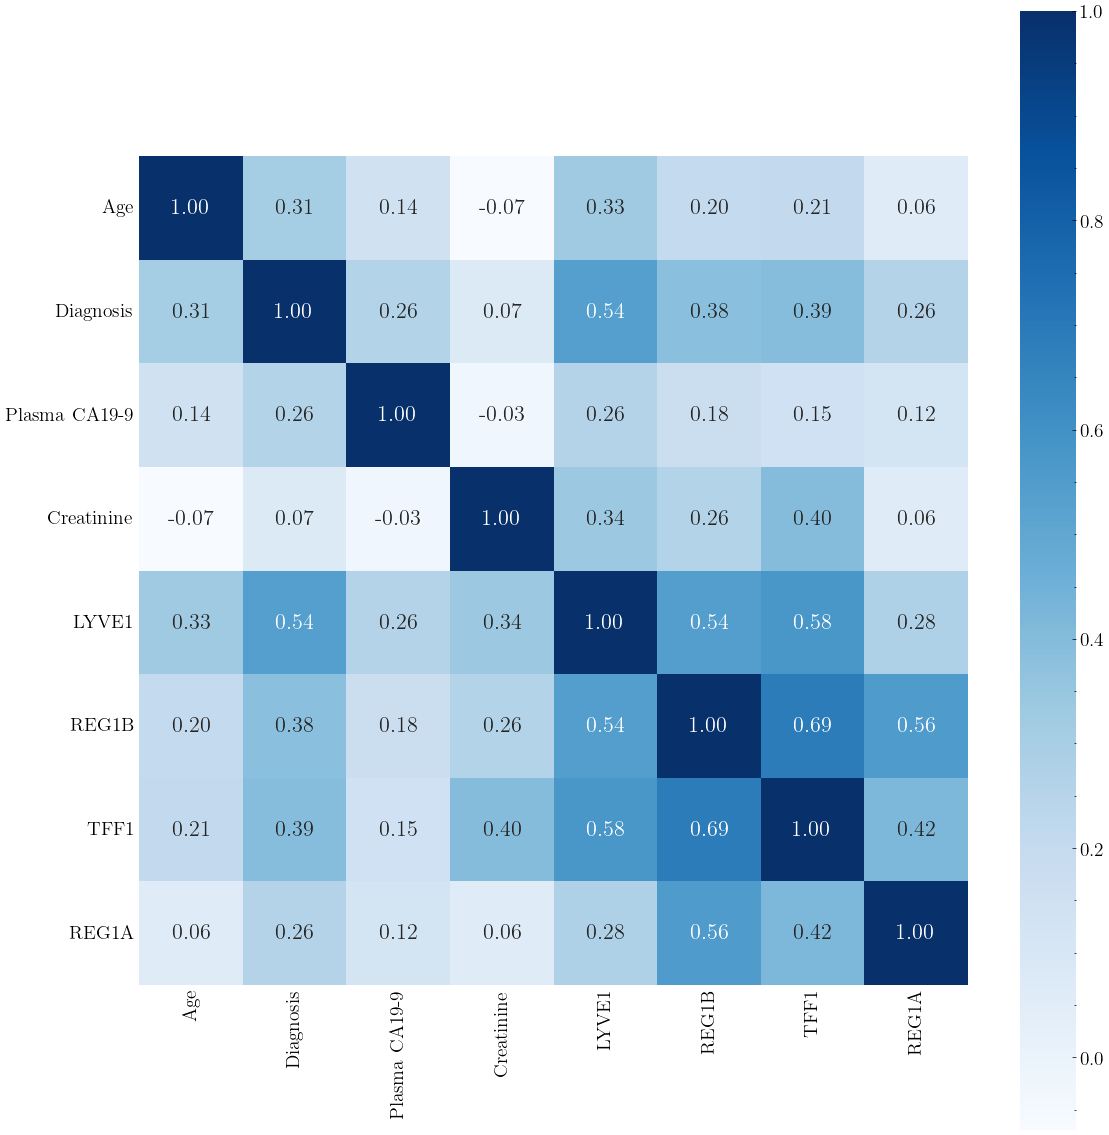

In [17]:
display_correlation(df_cancer)

**Age:**
* **Minimum:** 26
* **Maximum:** 89
* **Mean:** 59

**Sex:**
* **Male:** 291
* **Female:** 299

**Biomarkers:**
* **Creatinine** is a protein that is often used as an indicator of kidney function.
* **YVLE1** is lymphatic vessel endothelial hyaluronan receptor 1, a protein that may play a role in tumor metastasis
* **REG1B** is a protein that may be associated with pancreas regeneration
* **TFF1** is trefoil factor 1, which may be related to regeneration and repair of the urinary tract

<br>

* **Plasma CA19 9** is the blood plasma levels of CA 19–9 monoclonal antibody that is often elevated in patients with pancreatic cancer. It was only assessed in 350 patients
* **REG1A** is a protein that may be associated with pancreas regeneration. It was only assessed in 306 patients.


**Diagnoses:**
1. Control (no pancreatic disease)
2. Benign hepatobiliary disease (119 of which are chronic pancreatitis)
    * **Total:** 53
        * **Pancreatitis:** 41
        * **Pancreatitis (Chronic):** 35
        * **Gallstones:** 21
        * **Pancreatitis (Alcohol-Chronic):** 11
        * **Cholecystitis:** 9
3. Pancreatic ductal adenocarcinoma (i.e., pancreatic cancer)

**Stages:**
* I
* IA
* IB
* II
* IIA
* IIIB
* III
* IV

$$\text{\Huge{Data visualization}}$$

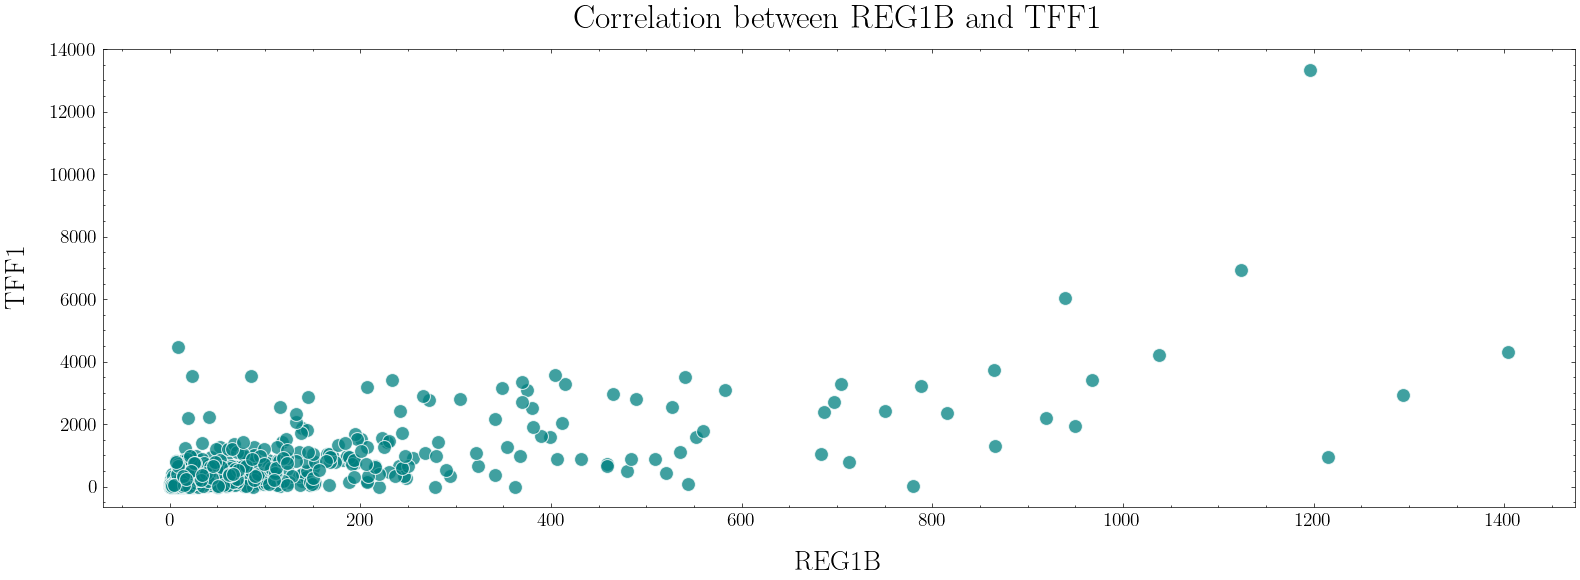

In [18]:
figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

sns.scatterplot(
    data=df_cancer,
    x='REG1B',
    y='TFF1',
    color='teal',
    s=100,
    alpha=0.75
)

ax.set_xlabel('REG1B')
ax.set_ylabel('TFF1')

ax.set_title('Correlation between REG1B and TFF1')

plt.tight_layout()
plt.show()
plt.close()

The following is a comparison between diagnoses, biomarkers and age. The biomarkers seem to be elevated in patients that suffer from cancer.

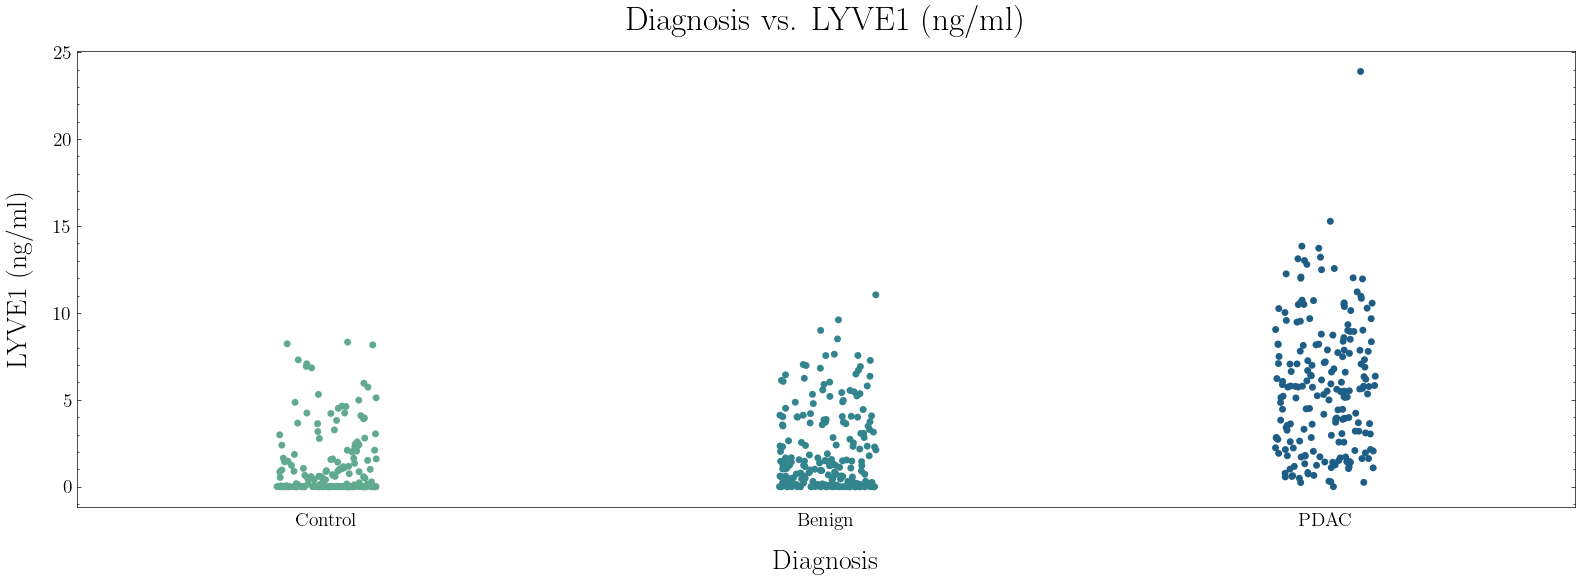

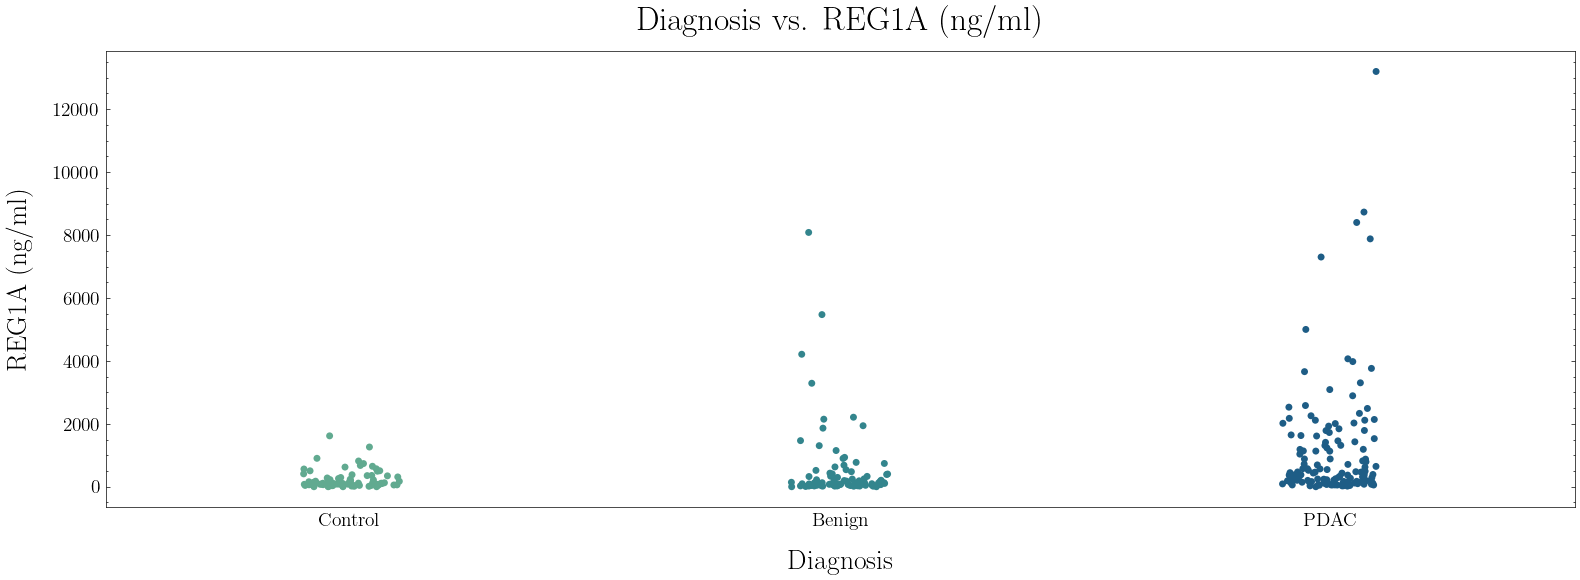

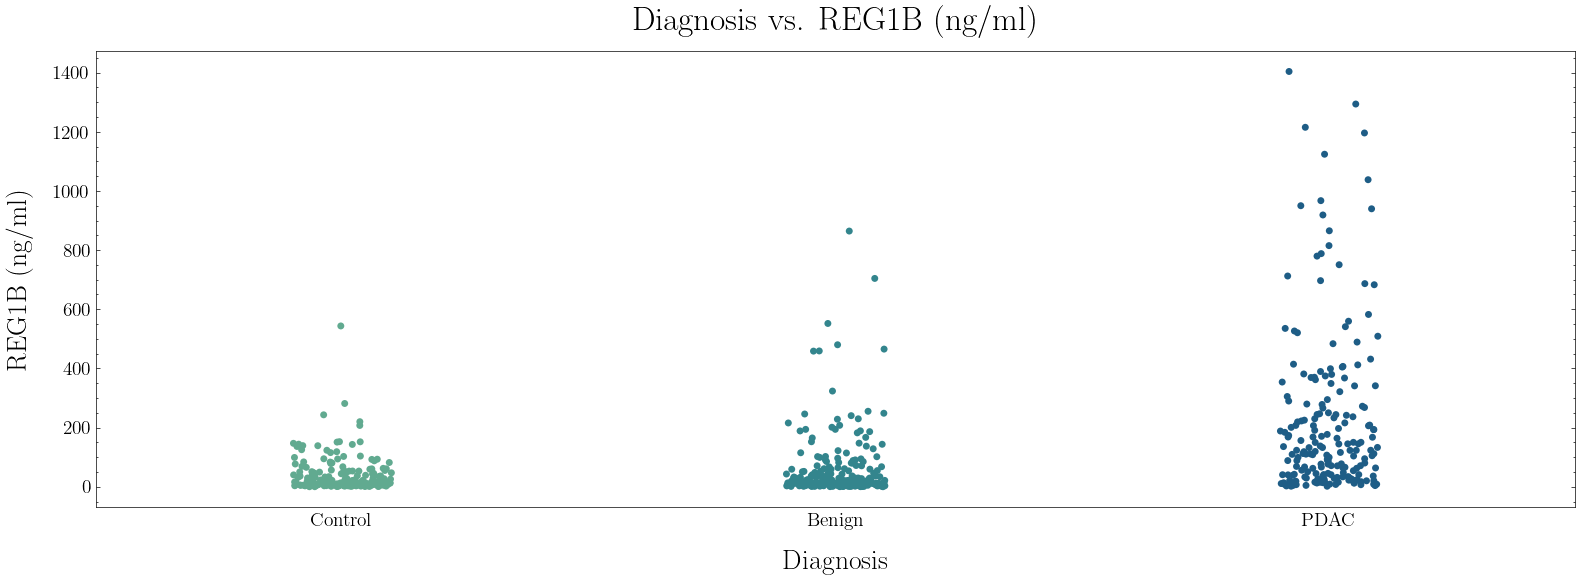

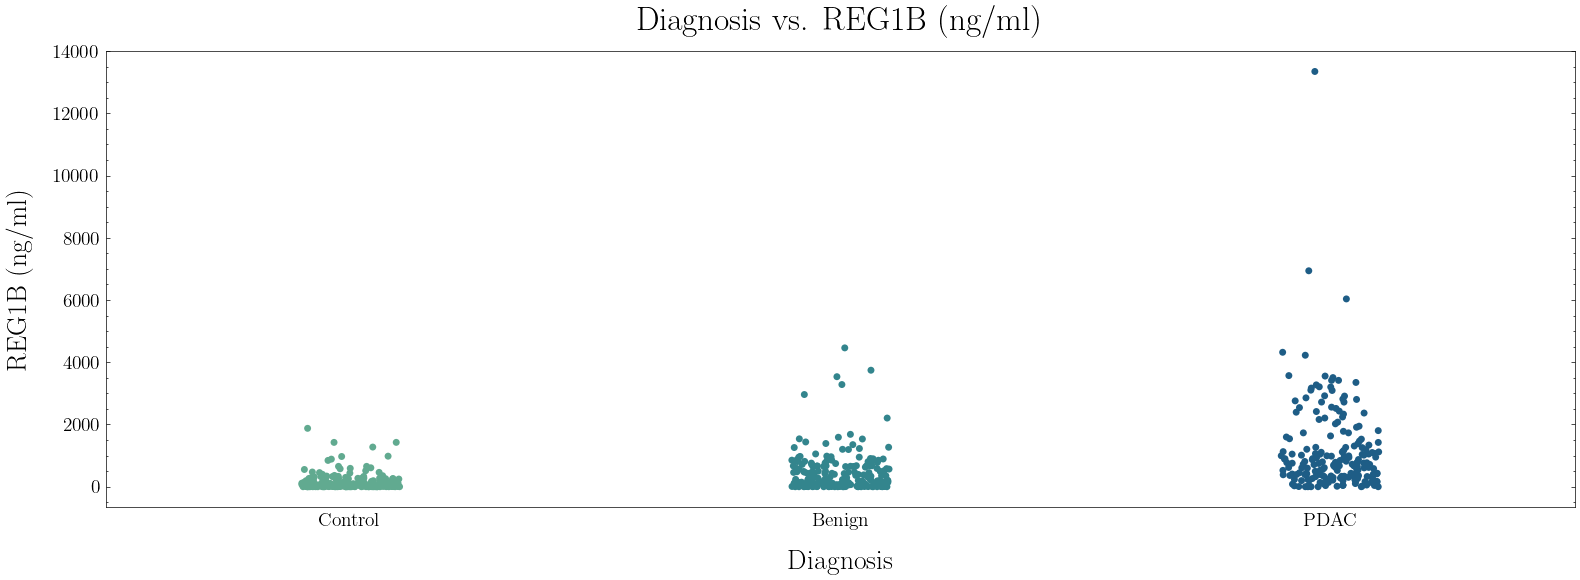

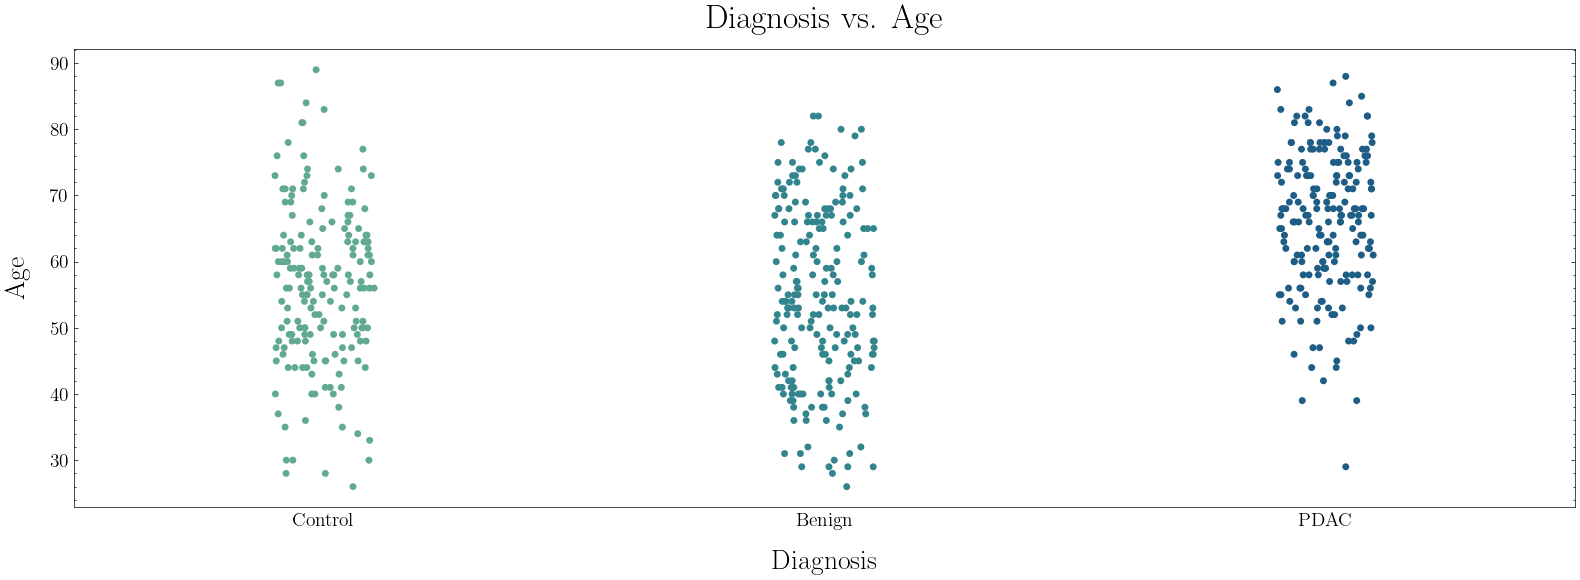

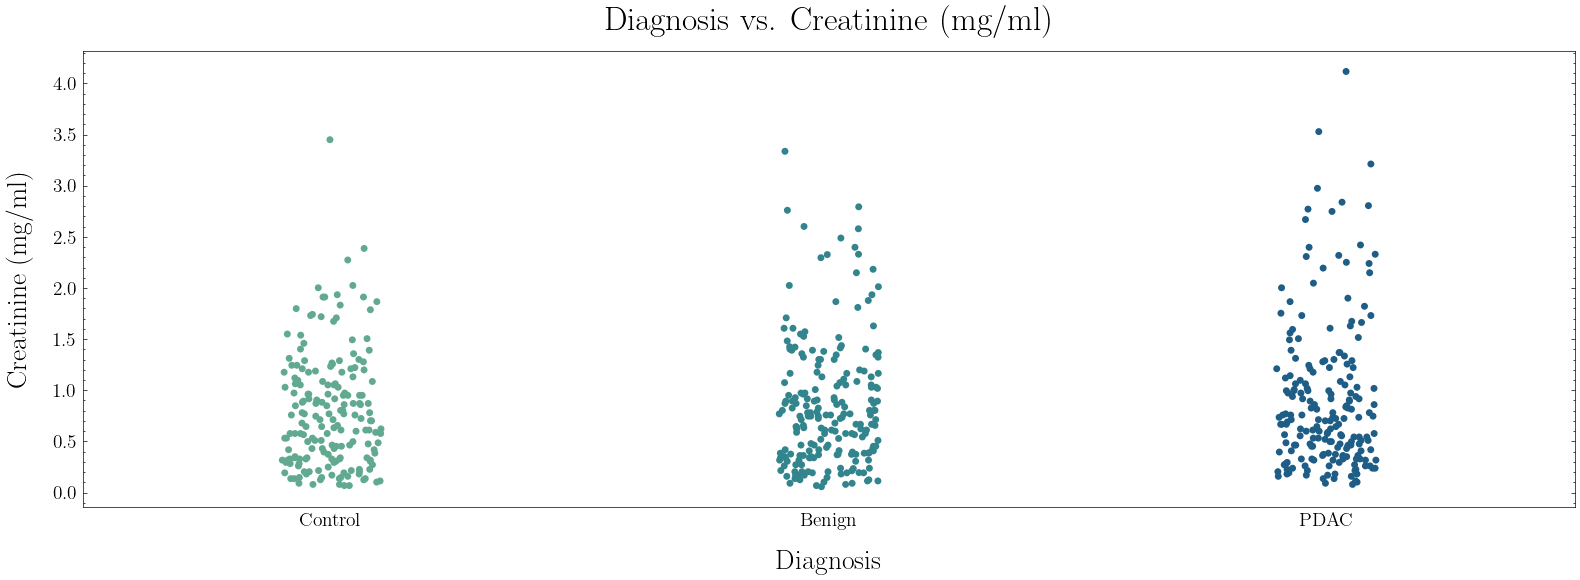

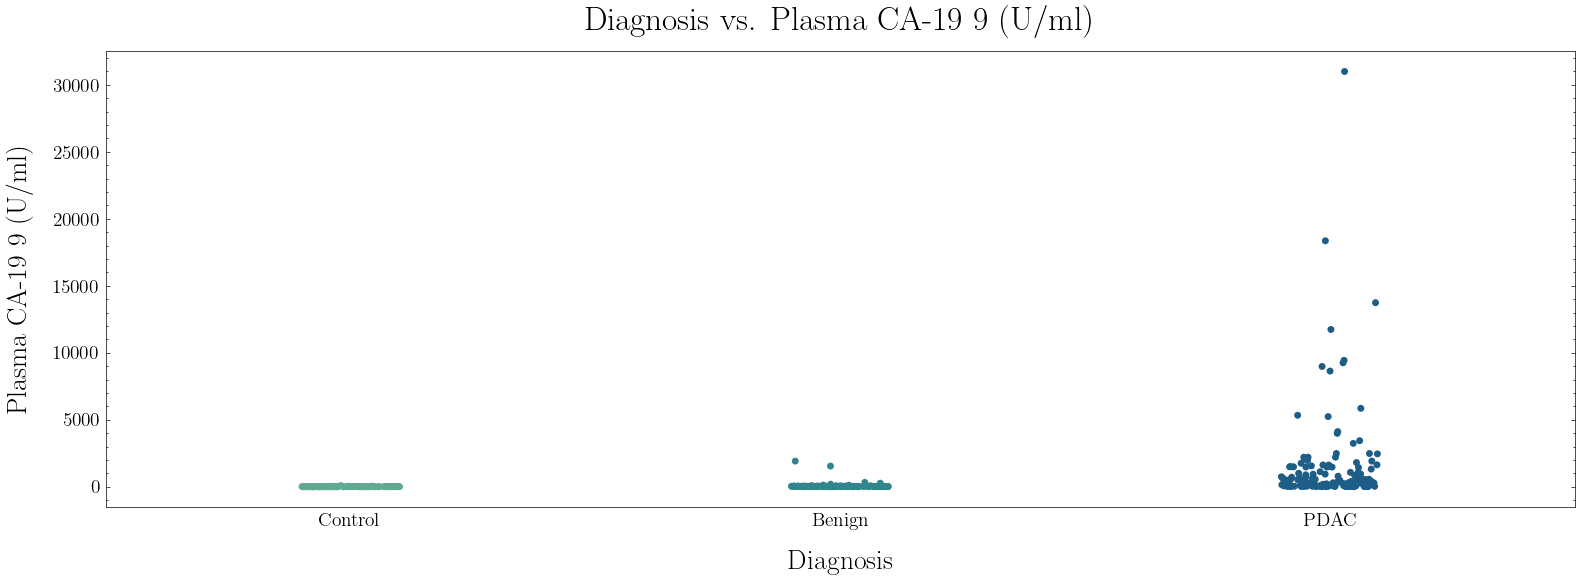

In [19]:
labels = [
    'Control',
    'Benign',
    'PDAC'
]

figsize = (16, 6)

for y in numerical:
    fig, ax = plt.subplots(figsize=figsize)

    x = 'diagnosis'
    
    sns.stripplot(
        data=df_cancer,
        x=x,
        y=y,
        hue=x,
        palette='crest',
    )

    biomarker = Biomarker.get_biomarker(y)

    x = column_to_title(x)

    if biomarker is None:
        y = column_to_title(y)
    else:
        y = biomarker

    locator = FixedLocator([0, 1, 2])
    ax.xaxis.set_major_locator(locator)
    ax.set_xticklabels(labels)

    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='y', which='both')

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    ax.set_title(f"{x} vs. {y}")

    plt.tight_layout()
    plt.show()
    print('\n')

plt.close('all')

The following is a comparison between the stages of cancer, biomarkers and age.

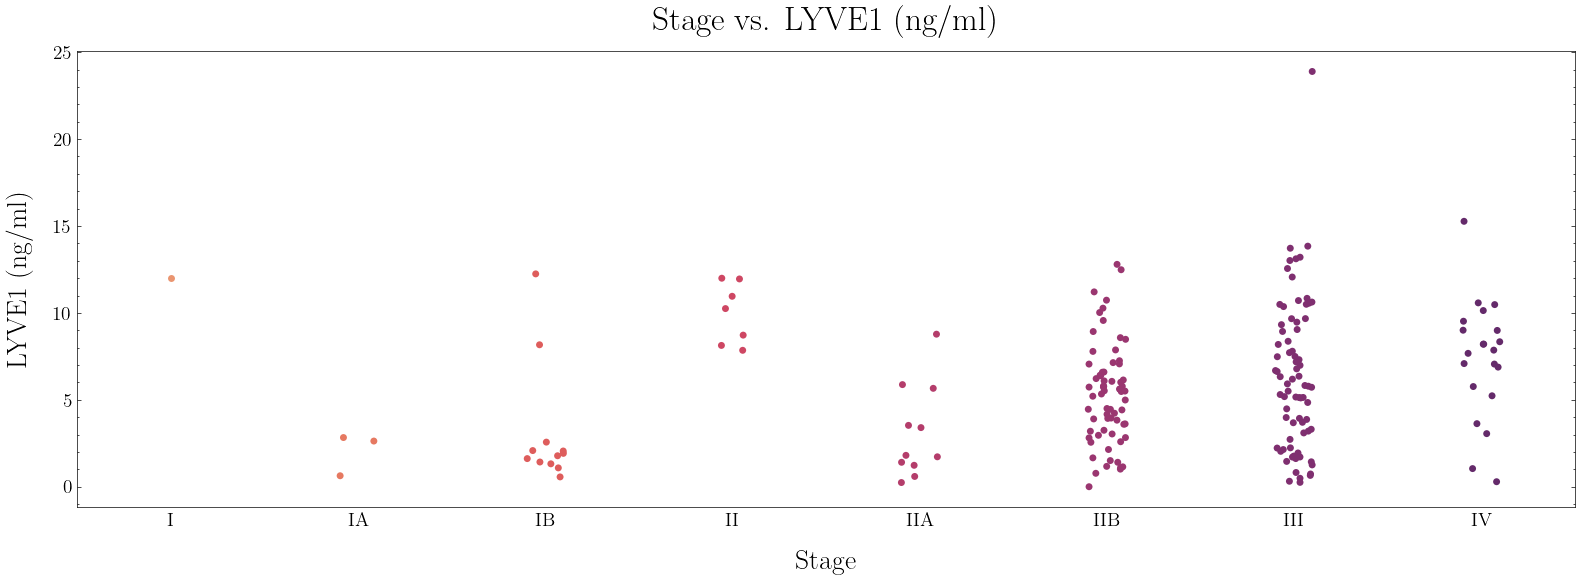

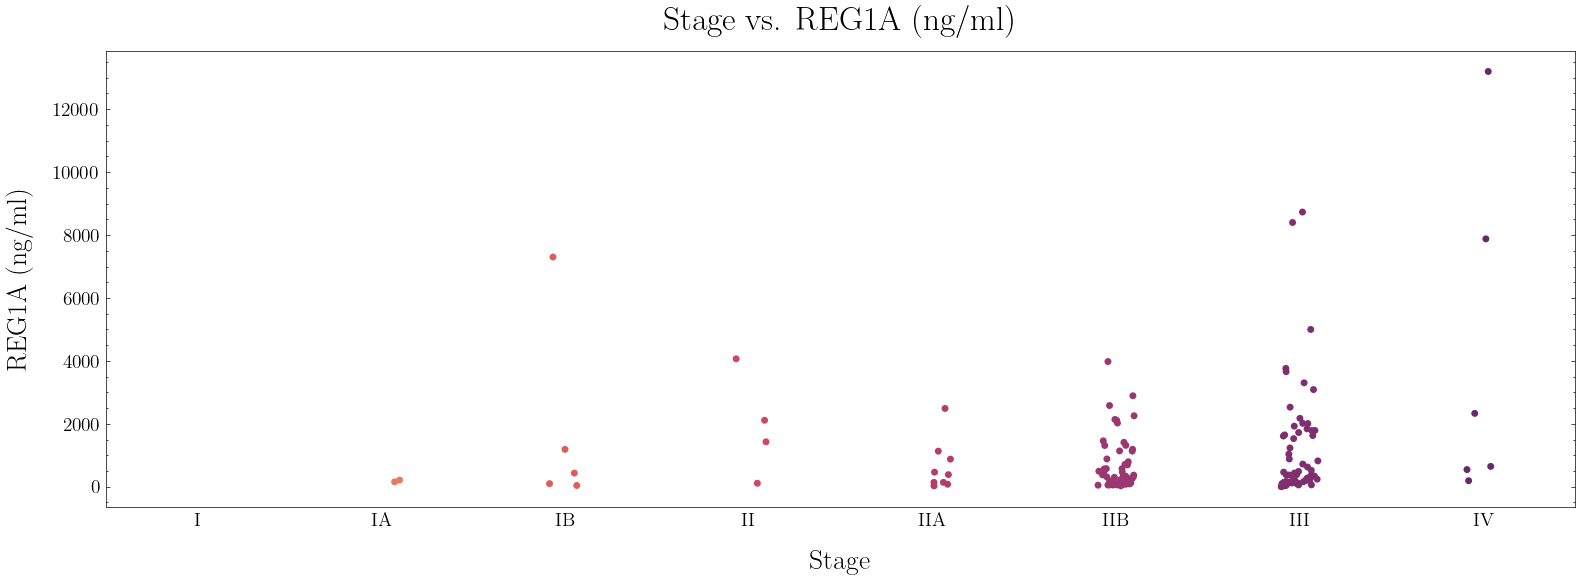

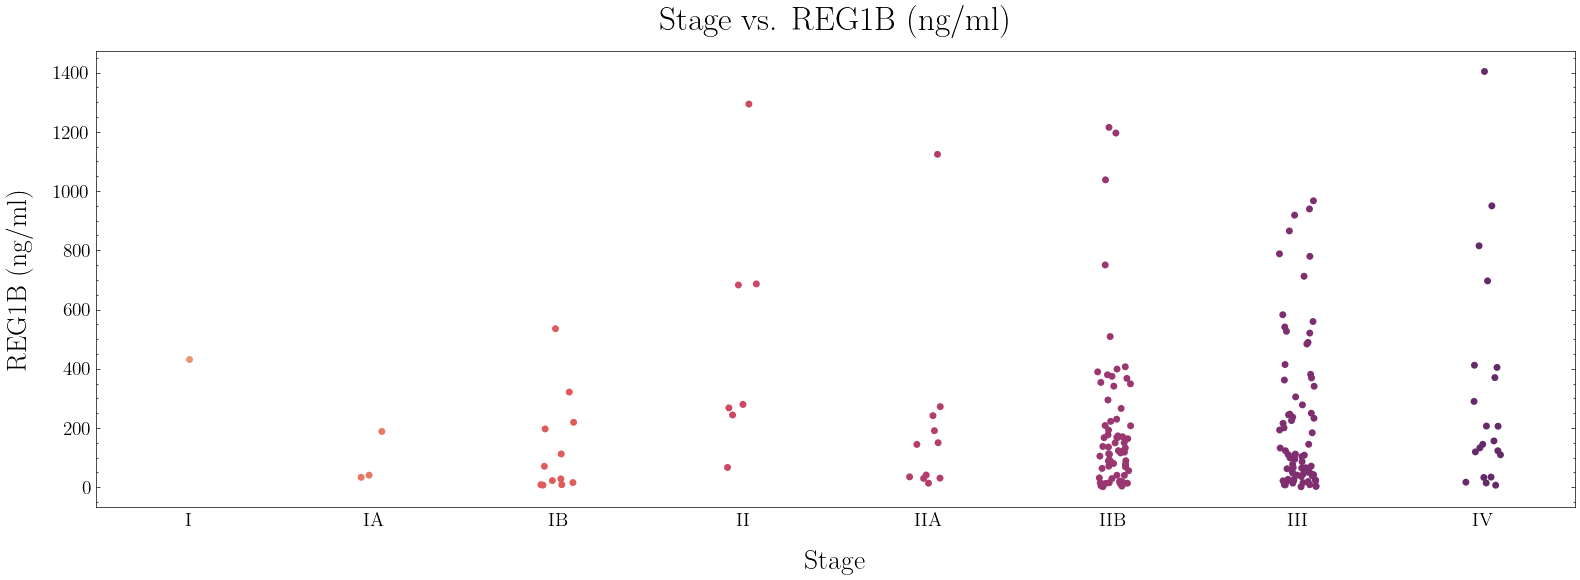

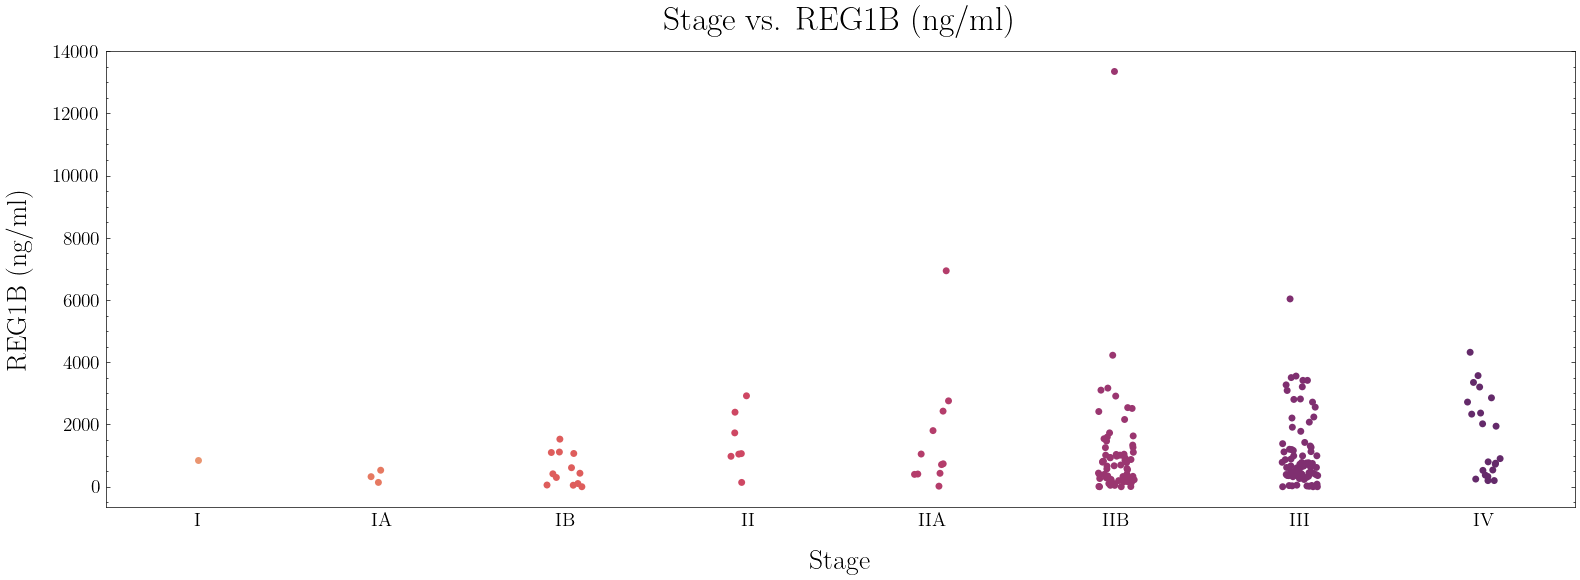

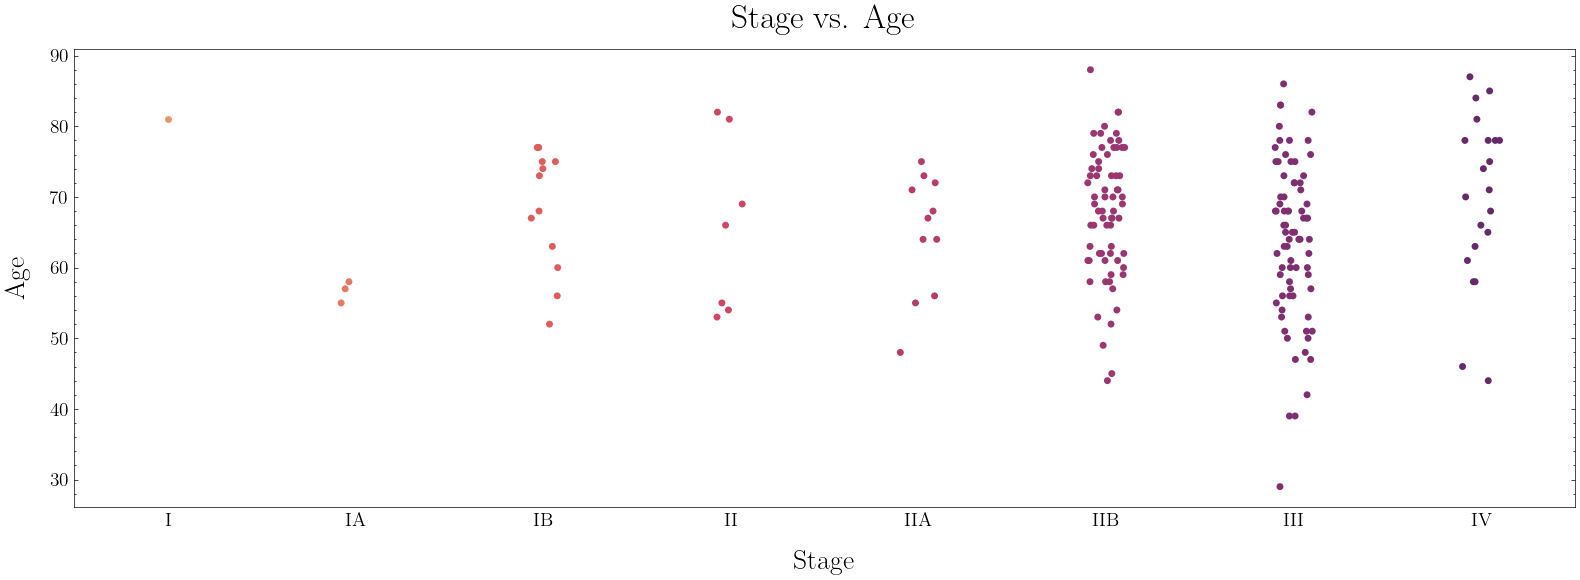

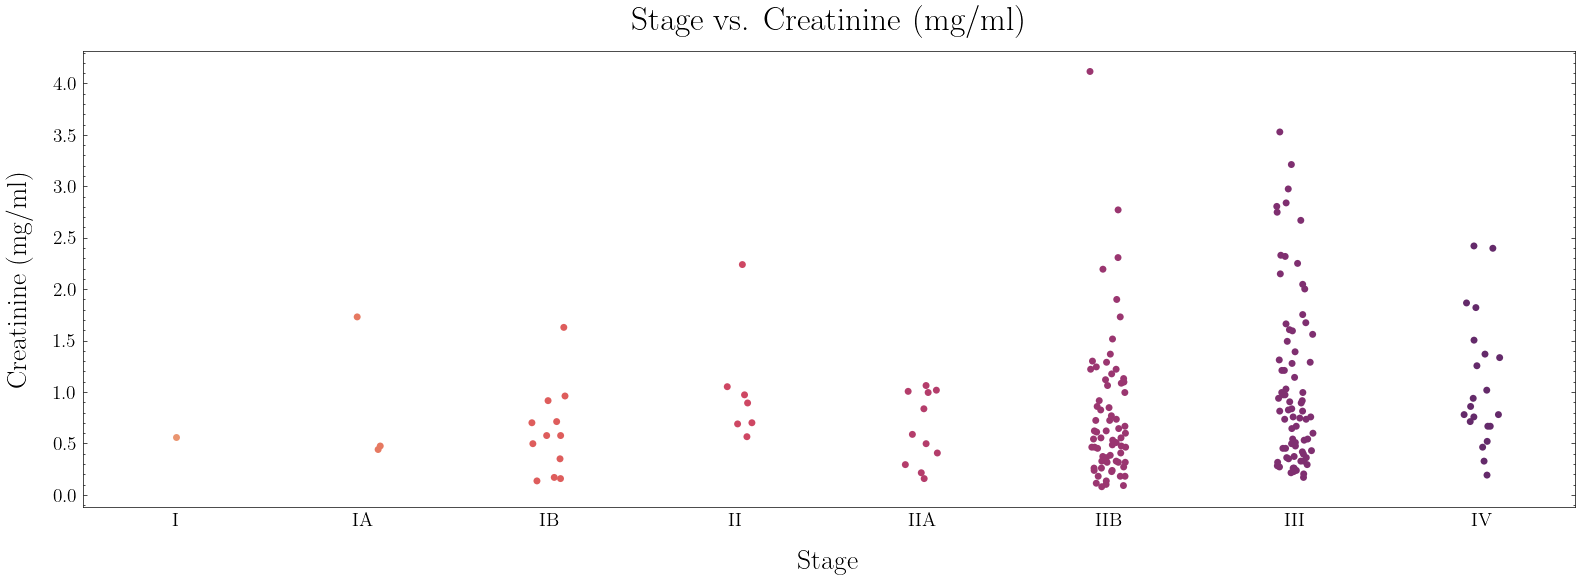

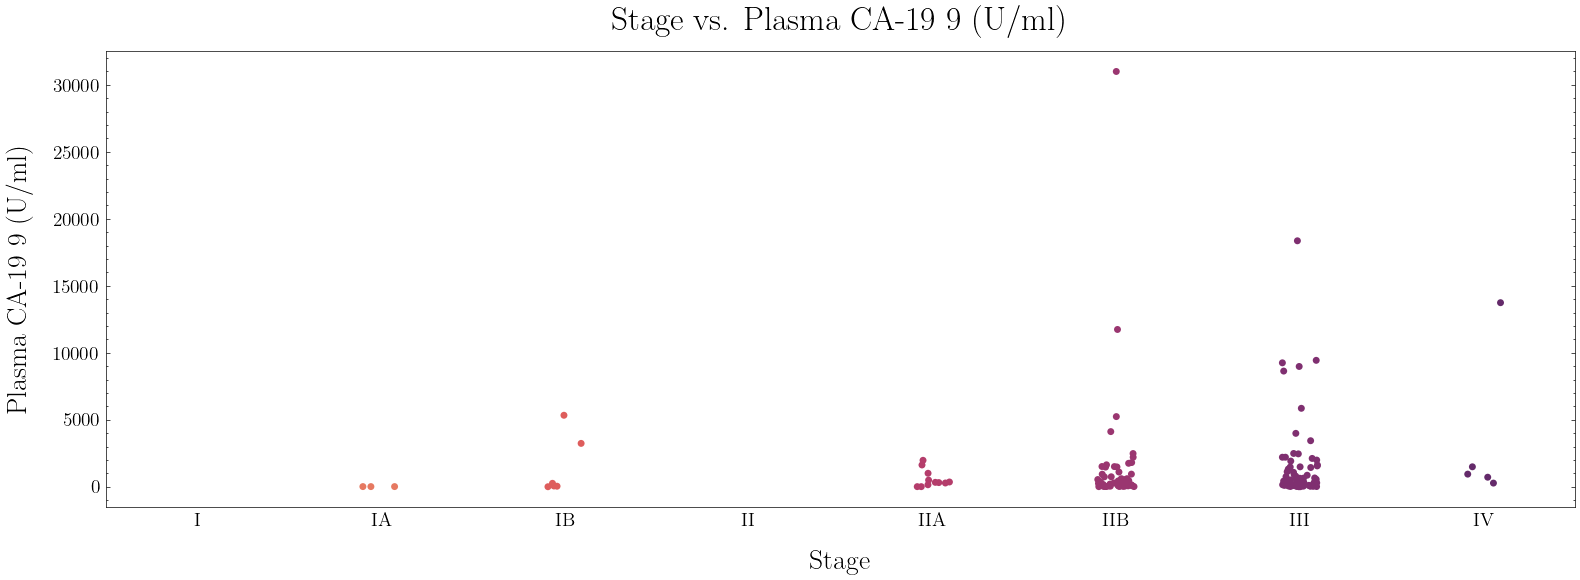

In [20]:
figsize = (16, 6)

for y in numerical:
    fig, ax = plt.subplots(figsize=figsize)

    x = 'stage'
    
    sns.stripplot(
        data=df_cancer[df_cancer['stage'].notna()],
        x=x,
        y=y,
        hue=x,
        palette='flare',
    )

    biomarker = Biomarker.get_biomarker(y)

    x = column_to_title(x)

    if biomarker is None:
        y = column_to_title(y)
    else:
        y = biomarker

    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='y', which='both')

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    ax.set_title(f"{x} vs. {y}")

    plt.tight_layout()
    plt.show()
    print('\n')

plt.close('all')

$$\text{\Huge{Data wrangling and preprocessing}}$$

Copy the original dataframe to experiment on a new dataframe without modifying the original.

In [21]:
df_diagnosis = df_cancer.copy()

Drop the unimportant column(s) from the dataframe.

In [22]:
drop = ['patient_cohort', 'sample_id', 'sample_origin']
df_diagnosis.drop(drop, axis=1, inplace=True)

In this dataset, `sex` is binary, so use One Hot Encoding to create a new column for each sex.

In [23]:
ohe = ['sex']

df_categorical = pd.get_dummies(df_diagnosis[ohe])

df_diagnosis = pd.concat([df_diagnosis, df_categorical], axis=1)

df_diagnosis = df_diagnosis.drop(ohe, axis=1)

Use Ordinal Encoding to transform the target/categorical variables: `benign_sample_diagnosis`, `diagnosis` and `stage`.

In [24]:
oe = [
    'benign_sample_diagnosis',
    'diagnosis',
    'stage'
]

encoder = OrdinalEncoder()

df_diagnosis[oe] = encoder.fit_transform(
    df_diagnosis[oe]
)

$$\text{\Huge{Build and test a model}}$$

The hyperparameters used in Model 1-4:

In [25]:
# colsample_bytree = [i for i in np.arange(0.8, 1.0, 0.1)]
# gamma = [0, 1, 5]
# max_depth = [i for i in range(2, 10, 2)]
# n_estimators = [i for i in range(1000, 5000, 1000)]
# subsample = [i for i in np.arange(0.8, 1.0, 0.1)]

The hyperparameters used in Model 5:

In [26]:
# colsample_bytree = [i for i in np.arange(0.5, 1.0, 0.1)]
# learning_rate = [0.01]
# max_depth = [i for i in range(2, 10, 2)]
# min_child_weight = [1, 3, 5]
# n_estimators = [250, 500]
# objective = ['multi:softmax']
# subsample = [i for i in np.arange(0.5, 1.0, 0.1)]

$$\text{\Huge{Model 1}}$$

In [27]:
predictor = [
    'creatinine',
    'LYVE1',
    'REG1B',
    'TFF1'
]

X = df_diagnosis[predictor]
y = df_diagnosis['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [28]:
scaler = StandardScaler()

X_train[predictor] = scaler.fit_transform(X_train[predictor])
X_test[predictor] = scaler.transform(X_test[predictor])

In [29]:
model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1,
    max_depth=8,
    n_estimators=2000,
    subsample=0.8
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

In [30]:
display_classification_score(y_test, y_pred_test, average='micro')

,Metric,Score
0,Accuracy,0.627119
1,Precision,0.627119
2,Recall,0.627119
3,F1,0.627119


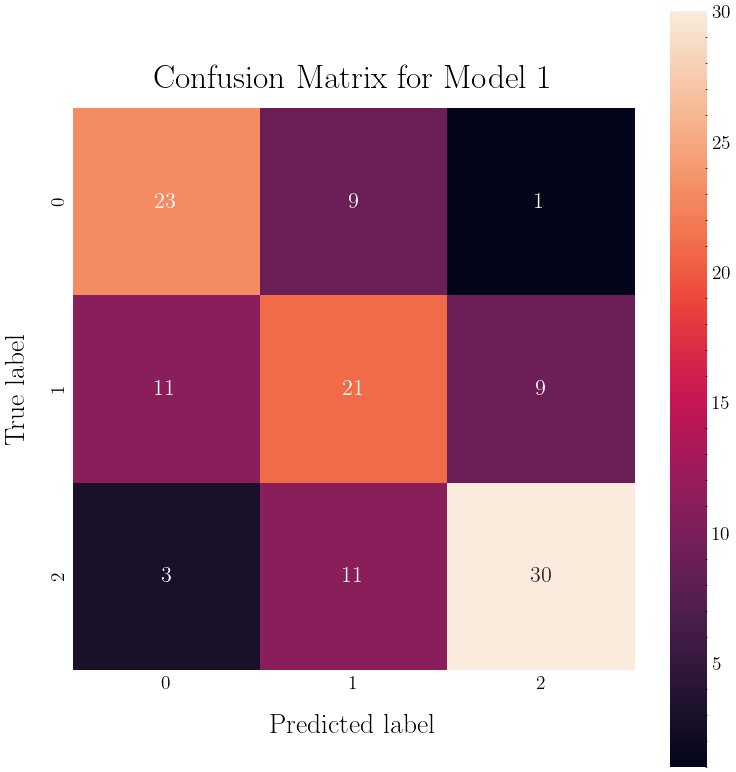

In [31]:
display_confusion_matrix(
    'Confusion Matrix for Model 1', 
    y_test, 
    y_pred_test
)

Use the model to predict the training data.

In [32]:
y_pred_train = model.predict(X_train)

In [33]:
display_classification_score(y_train, y_pred_train, average='micro')

,Metric,Score
0,Accuracy,0.90678
1,Precision,0.90678
2,Recall,0.90678
3,F1,0.90678


In [34]:
pi = permutation_importance(
    model,
    X=X_test,
    y=y_test,
    scoring='accuracy',
    n_repeats=30
)

df_importance = pd.DataFrame(
    {
        'variable': X_test.columns,
        'importance': pi.importances_mean.round(4),
        'sd': pi.importances_std.round(4)
    }
)

df_importance.sort_values(by='importance', ascending=False)

,variable,importance,sd
3,TFF1,0.1336,0.0322
1,LYVE1,0.1189,0.0386
2,REG1B,0.0782,0.0255
0,creatinine,0.0771,0.0257


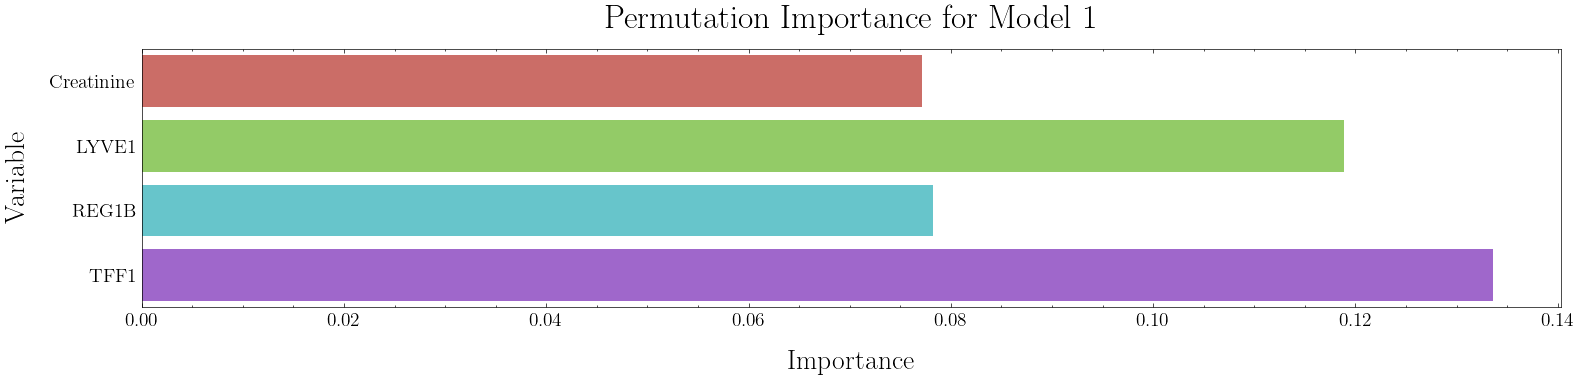

In [35]:
display_permutation_importance(df_importance, name='Model 1')

$$\text{\Huge{Model 2}}$$

In [36]:
predictor = [
    'age',
    'creatinine',
    'LYVE1',
    'REG1B',
    'sex_F',
    'sex_M',
    'TFF1'
]

X = df_diagnosis[predictor]
y = df_diagnosis['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [37]:
scaler = StandardScaler()

X_train[predictor] = scaler.fit_transform(X_train[predictor])
X_test[predictor] = scaler.transform(X_test[predictor])

In [38]:
model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1,
    max_depth=6,
    n_estimators=4000,
    subsample=0.9
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

In [39]:
display_classification_score(y_test, y_pred_test, average='micro')

,Metric,Score
0,Accuracy,0.567797
1,Precision,0.567797
2,Recall,0.567797
3,F1,0.567797


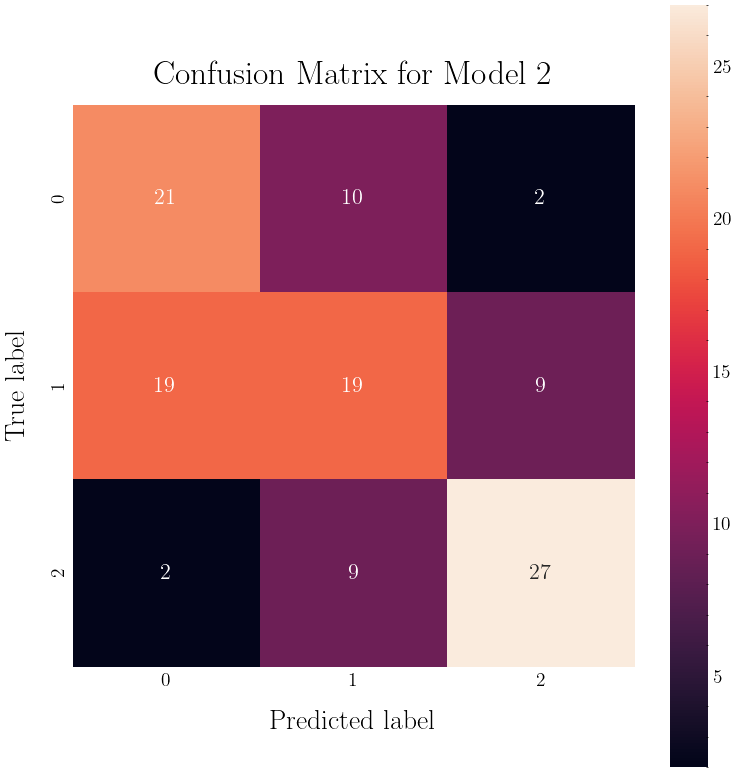

In [40]:
display_confusion_matrix(
    'Confusion Matrix for Model 2', 
    y_test, 
    y_pred_test
)

Use the model to predict the training data.

In [41]:
y_pred_train = model.predict(X_train)

In [42]:
display_classification_score(y_train, y_pred_train, average='micro')

,Metric,Score
0,Accuracy,0.900424
1,Precision,0.900424
2,Recall,0.900424
3,F1,0.900424


In [43]:
pi = permutation_importance(
    model,
    X=X_test,
    y=y_test,
    scoring='accuracy',
    n_repeats=30
)

df_importance = pd.DataFrame(
    {
        'variable': X_test.columns,
        'importance': pi.importances_mean.round(4),
        'sd': pi.importances_std.round(4)
    }
)

df_importance.sort_values(by='importance', ascending=False)

,variable,importance,sd
2,LYVE1,0.1401,0.0349
1,creatinine,0.0825,0.0301
0,age,0.0472,0.0307
6,TFF1,0.0331,0.0293
3,REG1B,0.0249,0.0239
5,sex_M,0.0037,0.0068
4,sex_F,-0.0079,0.0114


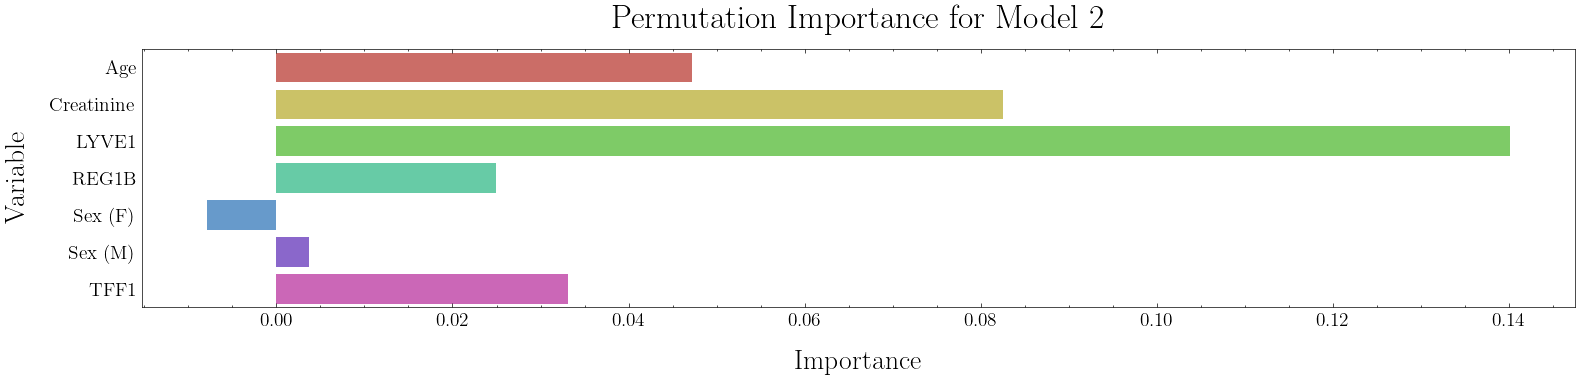

In [44]:
display_permutation_importance(df_importance, name='Model 2')

$$\text{\Huge{Model 3}}$$

In [45]:
predictor = [
    'age',
    'creatinine',
    'LYVE1',
    'plasma_CA19_9',
    'REG1A',
    'REG1B',
    'sex_F',
    'sex_M',
    'TFF1'
]

X = df_diagnosis[predictor]
y = df_diagnosis['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [46]:
scaler = StandardScaler()

X_train[predictor] = scaler.fit_transform(X_train[predictor])
X_test[predictor] = scaler.transform(X_test[predictor])

In [47]:
model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1,
    max_depth=8,
    n_estimators=4000,
    subsample=0.8
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

In [48]:
display_classification_score(y_test, y_pred_test, average='micro')

,Metric,Score
0,Accuracy,0.762712
1,Precision,0.762712
2,Recall,0.762712
3,F1,0.762712


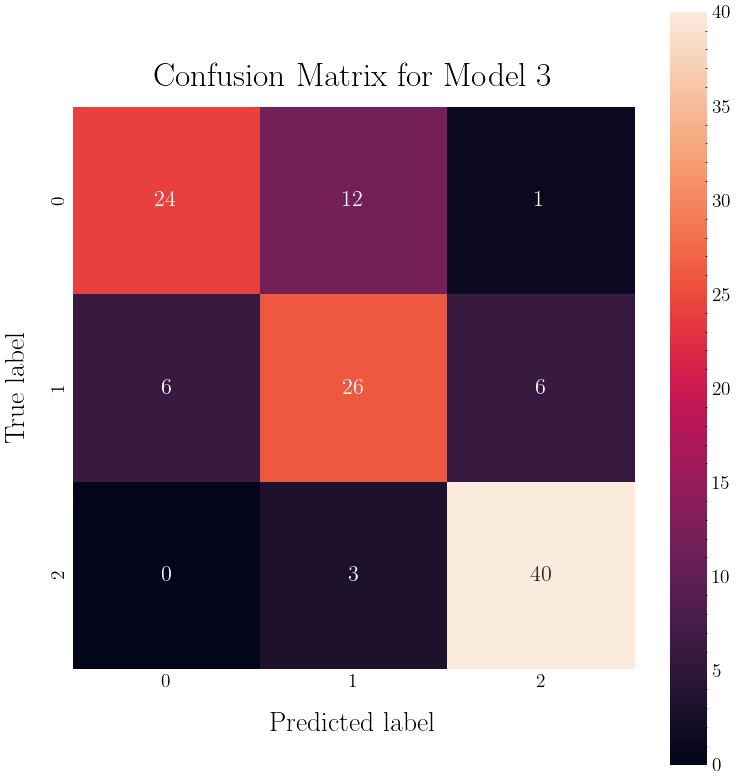

In [49]:
display_confusion_matrix(
    'Confusion Matrix for Model 3', 
    y_test, 
    y_pred_test
)

Use the model to predict the training data.

In [50]:
y_pred_train = model.predict(X_train)

In [51]:
display_classification_score(y_train, y_pred_train, average='micro')

,Metric,Score
0,Accuracy,0.96822
1,Precision,0.96822
2,Recall,0.96822
3,F1,0.96822


In [52]:
pi = permutation_importance(
    model,
    X=X_test,
    y=y_test,
    scoring='accuracy',
    n_repeats=30
)

df_importance = pd.DataFrame(
    {
        'variable': X_test.columns,
        'importance': pi.importances_mean.round(4),
        'sd': pi.importances_std.round(4)
    }
)

df_importance.sort_values(by='importance', ascending=False)

,variable,importance,sd
3,plasma_CA19_9,0.2124,0.0316
2,LYVE1,0.1847,0.0298
8,TFF1,0.0983,0.0265
0,age,0.0777,0.0342
4,REG1A,0.0653,0.0218
5,REG1B,0.0514,0.0192
1,creatinine,0.0472,0.0188
7,sex_M,0.0076,0.0059
6,sex_F,0.0073,0.0084


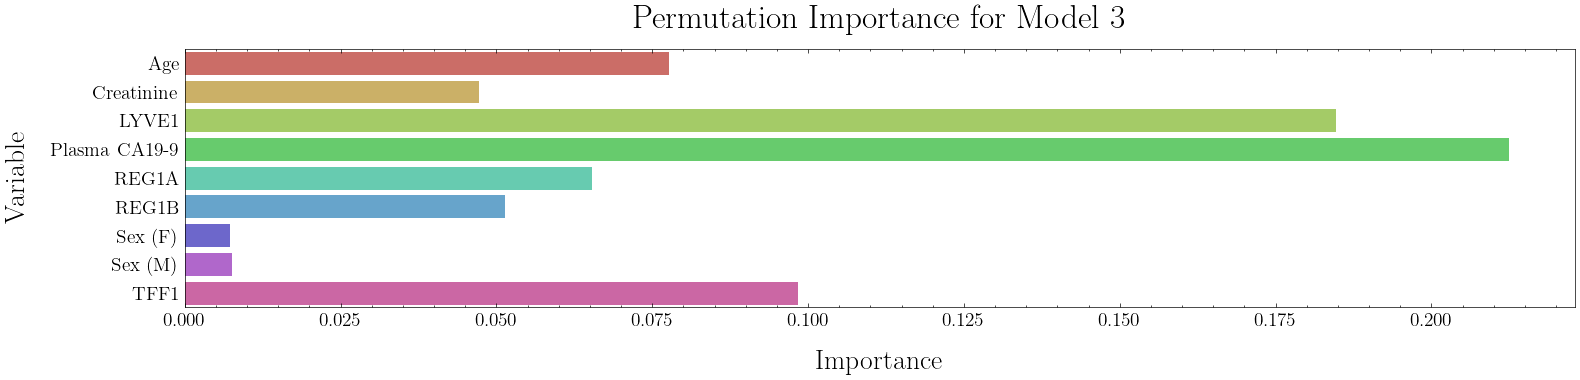

In [53]:
display_permutation_importance(df_importance, name='Model 3')

$$\text{\Huge{Model 4}}$$

In [54]:
df_experimental = df_diagnosis.copy()

In [55]:
target = [
    'benign_sample_diagnosis',
    'diagnosis',
    'stage'
]

Get the indices of each NaN cell for the `plasma_CA19_9` column.

In [56]:
indices = df_experimental[df_experimental['plasma_CA19_9'].isnull()].index.to_list()

train = df_experimental.drop(indices, axis=0)
test = df_experimental[df_experimental.index.isin(indices)]

train = train.drop(target, axis=1)
test = test.drop(target, axis=1)

Insert the predicted `plasma_CA19_9` amount into the NaN cell.

In [57]:
model = XGBRegressor(
    colsample_bytree=0.6,
    gamma=0.5,
    max_depth=3,
    min_child_weight=1,
    objective='reg:squarederror',
    subsample=0.6
)

model.fit(
    train.drop('plasma_CA19_9', axis=1),
    train['plasma_CA19_9']
)

prediction = model.predict(
    test.drop('plasma_CA19_9', axis=1)
)

df_experimental.loc[indices, 'plasma_CA19_9'] = prediction

Get the indices of each NaN cell for the `REG1A` column.

In [58]:
indices = df_experimental[df_experimental['REG1A'].isnull()].index.to_list()

train = df_experimental.drop(indices, axis=0)
test = df_experimental[df_experimental.index.isin(indices)]

train = train.drop(target, axis=1)
test = test.drop(target, axis=1)

Insert the predicted `REG1A` amount into the NaN cell.

In [59]:
model = XGBRegressor(
    colsample_bytree=0.6,
    gamma=0.5,
    max_depth=3,
    min_child_weight=1,
    objective='reg:squarederror',
    subsample=0.6
)

model.fit(
    train.drop('REG1A', axis=1),
    train['REG1A']
)

prediction = model.predict(
    test.drop('REG1A', axis=1)
)

df_experimental.loc[indices, 'REG1A'] = prediction

In [60]:
df_experimental.head(25)

,age,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,sex_F,sex_M
0,33,0.0,NaN,NaN,11.700000,1.83222,0.893219,52.948840,654.282174,1262.000000,True,False
1,81,0.0,NaN,NaN,334.960938,0.97266,2.037585,94.467030,209.488250,228.407000,True,False
2,51,0.0,NaN,NaN,7.000000,0.78039,0.145589,102.366000,461.141000,617.147400,False,True
3,61,0.0,NaN,NaN,8.000000,0.70122,0.002805,60.579000,142.950000,7.293686,False,True
4,62,0.0,NaN,NaN,9.000000,0.21489,0.000860,65.540000,41.088000,-176.581100,False,True
5,53,0.0,NaN,NaN,86.451981,0.84825,0.003393,62.126000,59.793000,-29.217878,False,True
6,70,0.0,NaN,NaN,-614.839417,0.62205,0.174381,152.277000,117.516000,-522.685852,False,True
7,58,0.0,NaN,NaN,11.000000,0.89349,0.003574,3.730000,40.294000,-316.637939,True,False
8,59,0.0,NaN,NaN,126.157936,0.48633,0.001945,7.021000,26.782000,-150.957581,True,False
9,56,0.0,NaN,NaN,24.000000,0.61074,0.278778,83.928000,19.185000,518.995178,True,False


In [61]:
predictor = [
    'age',
    'creatinine',
    'LYVE1',
    'plasma_CA19_9',
    'REG1A',
    'REG1B',
    'sex_F',
    'sex_M',
    'TFF1'
]

X = df_experimental[predictor]
y = df_experimental['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [62]:
scaler = StandardScaler()

X_train[predictor] = scaler.fit_transform(X_train[predictor])
X_test[predictor] = scaler.transform(X_test[predictor])

In [63]:
model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1,
    max_depth=8,
    n_estimators=4000,
    subsample=0.8
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

In [64]:
display_classification_score(y_test, y_pred_test, average='micro')

,Metric,Score
0,Accuracy,0.644068
1,Precision,0.644068
2,Recall,0.644068
3,F1,0.644068


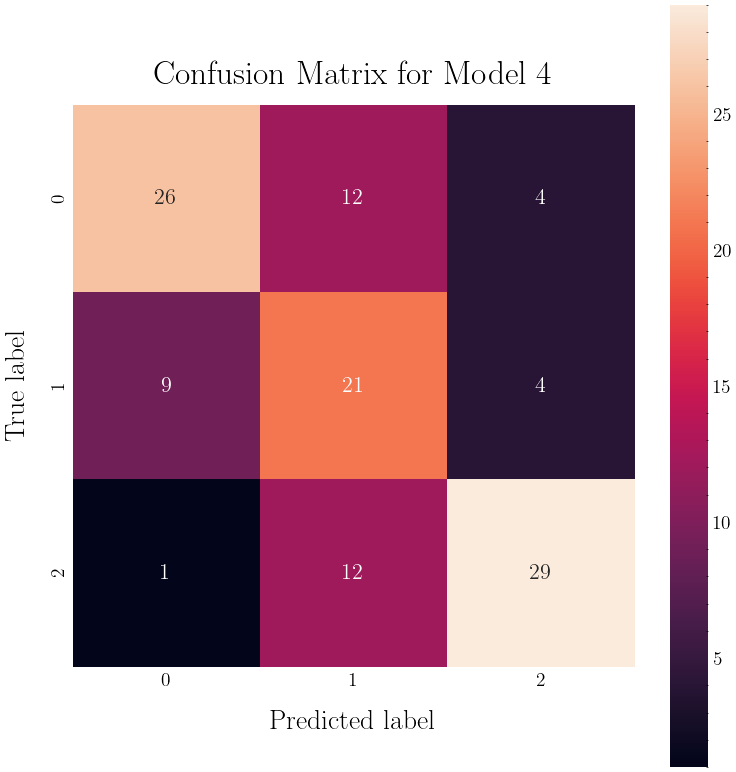

In [65]:
display_confusion_matrix(
    'Confusion Matrix for Model 4', 
    y_test, 
    y_pred_test
)

Use the model to predict the training data.

In [66]:
y_pred_train = model.predict(X_train)

In [67]:
display_classification_score(y_train, y_pred_train, average='micro')

,Metric,Score
0,Accuracy,0.95339
1,Precision,0.95339
2,Recall,0.95339
3,F1,0.95339


In [68]:
pi = permutation_importance(
    model,
    X=X_test,
    y=y_test,
    scoring='accuracy',
    n_repeats=30
)

df_importance = pd.DataFrame(
    {
        'variable': X_test.columns,
        'importance': pi.importances_mean.round(4),
        'sd': pi.importances_std.round(4)
    }
)

df_importance.sort_values(by='importance', ascending=False)

,variable,importance,sd
2,LYVE1,0.1062,0.0294
3,plasma_CA19_9,0.0927,0.0196
0,age,0.0751,0.0255
8,TFF1,0.0723,0.0298
1,creatinine,0.0503,0.0227
4,REG1A,0.0370,0.0209
5,REG1B,0.0232,0.0232
6,sex_F,0.0093,0.0136
7,sex_M,0.0000,0.0000


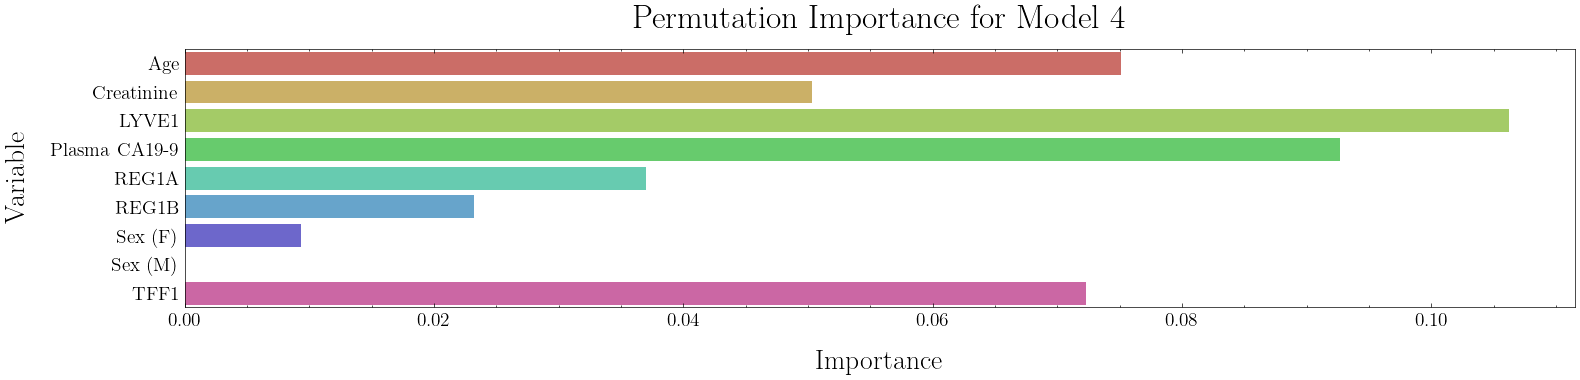

In [69]:
display_permutation_importance(df_importance, name='Model 4')

$$\text{\Huge{Model 5}}$$

In [70]:
predictor = [
    'creatinine',
    'LYVE1',
    'plasma_CA19_9',
    'TFF1'
]

X = df_diagnosis[predictor]
y = df_diagnosis['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [71]:
scaler = StandardScaler()

X_train[predictor] = scaler.fit_transform(X_train[predictor])
X_test[predictor] = scaler.transform(X_test[predictor])

In [72]:
eval_metric = ['merror', 'mlogloss']
eval_set = [(X_train, y_train), (X_test, y_test)]

model = XGBClassifier(
    colsample_bytree=0.8,
    eval_metric=eval_metric,
    gamma=0,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=1,
    n_estimators=250,
    objective='multi:softmax',
    subsample=0.7
)

model.fit(
    X_train,
    y_train,
    eval_set=eval_set,    
    verbose=False
)

y_pred_test = model.predict(X_test)

In [73]:
results = model.evals_result()

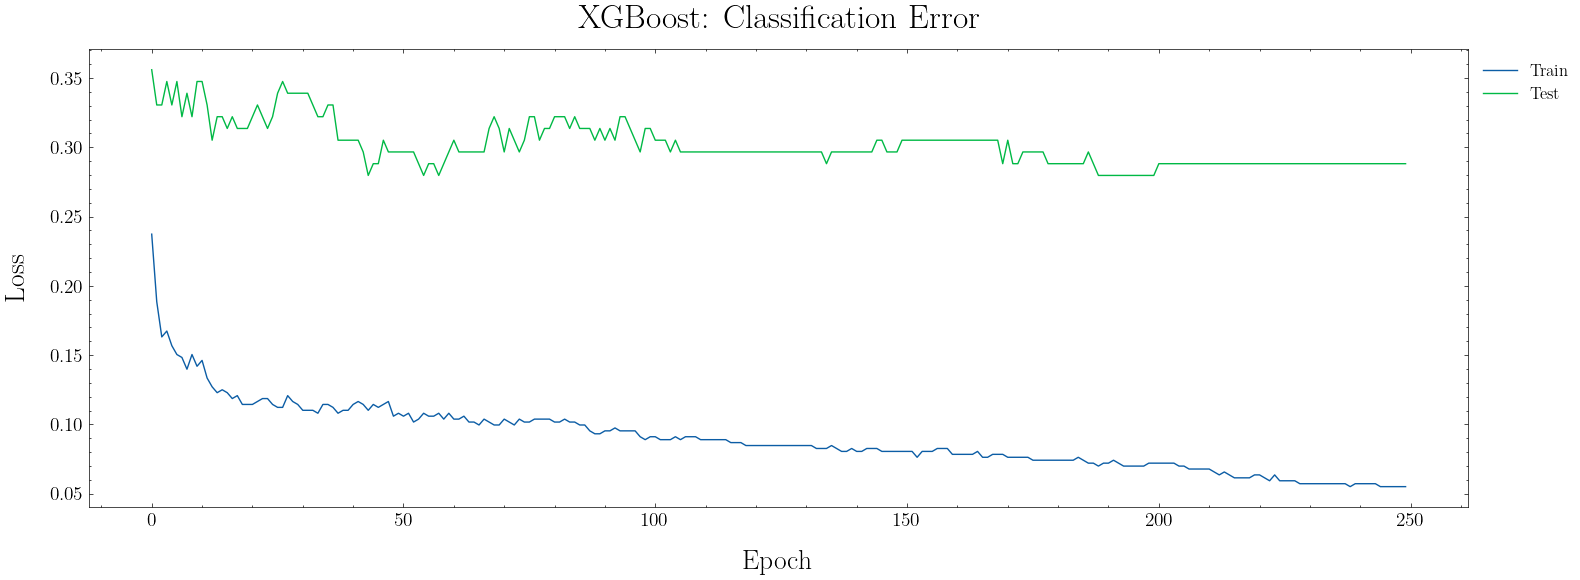

In [74]:
x = results.get('validation_0').get('merror')
y = results.get('validation_1').get('merror')

epoch = range(
    0,
    len(x)
)

figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(epoch, x, label='Train')
ax.plot(epoch, y, label='Test')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.set_title('XGBoost: Classification Error')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

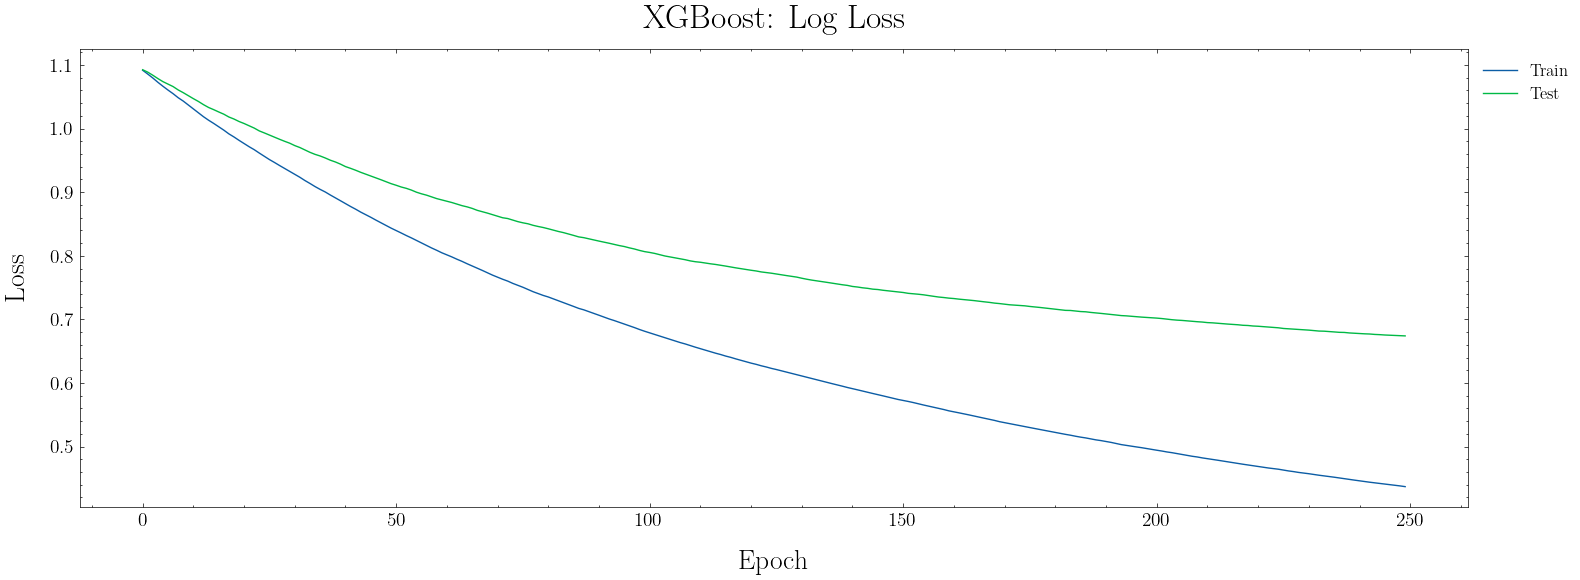

In [75]:
x = results.get('validation_0').get('mlogloss')
y = results.get('validation_1').get('mlogloss')

epoch = range(
    0,
    len(x)
)

figsize = (16, 6)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(epoch, x, label='Train')
ax.plot(epoch, y, label='Test')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.title('XGBoost: Log Loss')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

In [76]:
display_classification_score(y_test, y_pred_test, average='micro')

,Metric,Score
0,Accuracy,0.711864
1,Precision,0.711864
2,Recall,0.711864
3,F1,0.711864


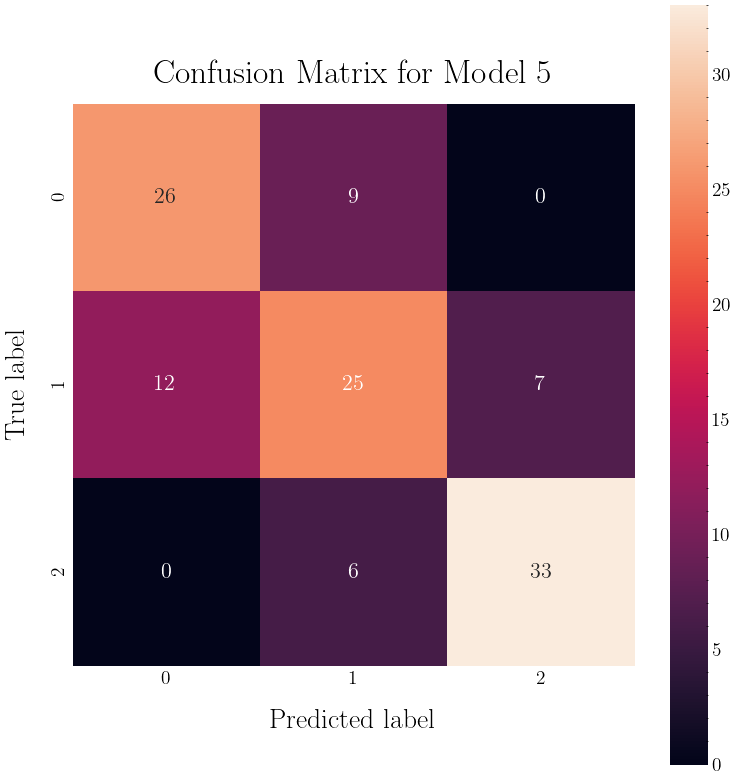

In [77]:
display_confusion_matrix(
    'Confusion Matrix for Model 5', 
    y_test, 
    y_pred_test
)

Use the model to predict the training data.

In [78]:
y_pred_train = model.predict(X_train)

In [79]:
display_classification_score(y_train, y_pred_train, average='micro')

,Metric,Score
0,Accuracy,0.944915
1,Precision,0.944915
2,Recall,0.944915
3,F1,0.944915


In [80]:
pi = permutation_importance(
    model,
    X=X_test,
    y=y_test,
    scoring='accuracy',
    n_repeats=30
)

df_importance = pd.DataFrame(
    {
        'variable': X_test.columns,
        'importance': pi.importances_mean.round(4),
        'sd': pi.importances_std.round(4)
    }
)

df_importance.sort_values(by='importance', ascending=False)

,variable,importance,sd
2,plasma_CA19_9,0.1701,0.0306
3,TFF1,0.0963,0.0292
0,creatinine,0.0918,0.0303
1,LYVE1,0.0915,0.0246


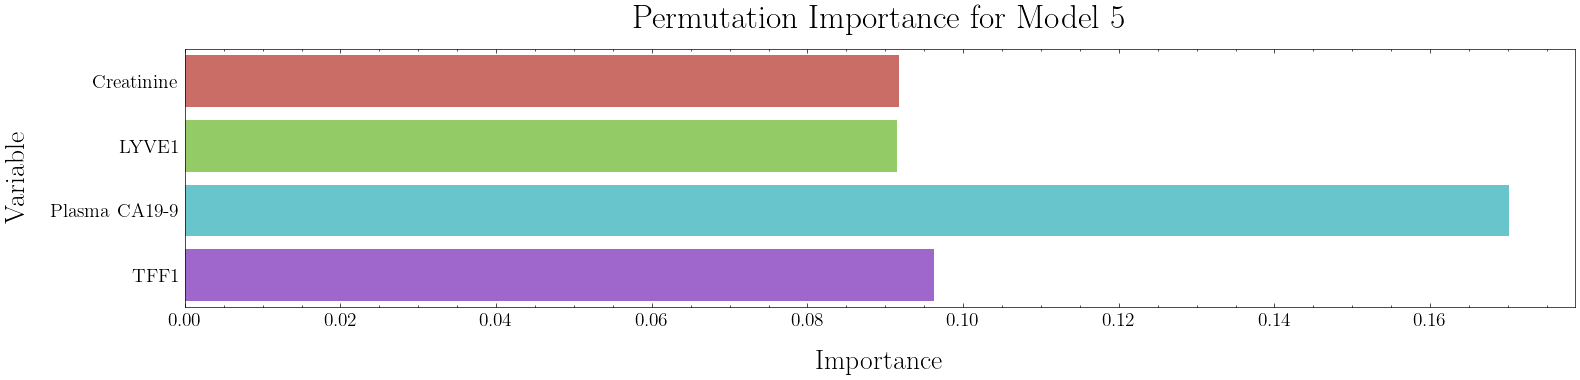

In [81]:
display_permutation_importance(df_importance, name='Model 5')

I created varying `XGBClassifier`s, but included or excluded more features in each model. The more features included seemed to render better scores, thus making it challenging to predict a diagnosis based on the four key biomarkers: *creatinine*, *LYVE1*, *REG1B* and *TFF1*. I also used `GridSearchCV` to search for the best hyperparameters for each model. [Model 1](https://colab.research.google.com/drive/1DK3R_KOmReBNUCqNlofBK26NPGAz8nm6#scrollTo=4FwjpKKqf8AE&line=1&uniqifier=1) ranged from 50-60%, [Model 2](https://colab.research.google.com/drive/1DK3R_KOmReBNUCqNlofBK26NPGAz8nm6#scrollTo=wjgPDjvlgJb5&line=1&uniqifier=1) ranged from 60-70% and [Model 3](https://colab.research.google.com/drive/1DK3R_KOmReBNUCqNlofBK26NPGAz8nm6#scrollTo=QtkYWRfejXXD&line=1&uniqifier=1) ranged from 70-75% for accuracy, precision, recall and F1 scores. In [Model 4](https://colab.research.google.com/drive/1DK3R_KOmReBNUCqNlofBK26NPGAz8nm6#scrollTo=AG87DjBpmwb-), I built upon [Model 3](https://colab.research.google.com/drive/1DK3R_KOmReBNUCqNlofBK26NPGAz8nm6#scrollTo=QtkYWRfejXXD&line=1&uniqifier=1), and tried to predict the missing data in *plasma_CA19_9* and *REG1A* using a `XGBRegressor`, but it did not improve the model's ability to predict a diagnosis.

In [Model 5](https://colab.research.google.com/drive/1DK3R_KOmReBNUCqNlofBK26NPGAz8nm6#scrollTo=pzRwnssRhtIz), I was able to build a simpler model using less features. On average, it had roughly the same scoring as [Model 3](https://colab.research.google.com/drive/1DK3R_KOmReBNUCqNlofBK26NPGAz8nm6#scrollTo=QtkYWRfejXXD&line=1&uniqifier=1). I also introduced new parameters to tune it better. However, the generalization was not great. The scoring on the training dataset typically exceeded that of the testing dataset. I was able to bring the scoring within $\pm$ 10 between the training and testing by tweaking the hyperparameters. However, it brought the scores of the training and testing to ~70 and ~60 respectively, but I was unsure which was better; a model that was overfit vs. low scoring on both datasets.

I used `GridSearchCV` to find the best hyperparameters, but I chose to do it on my machine as it is much faster than Google Colab. I have left the cell(s) related to `GridSearchCV` commented out with the range of options and hyperparameters that I used.

$$\text{\Huge{Interpretation}}$$

Plasma CA 19-9 seemed to contribute a lot to the prediction, which was unsurprising to me. It was documented that it was "*often elevated in patients with pancreatic cancer.*" This was also reflected in the data visualization. I compared the Plasma CA 19-9 level for each diagnosis (i.e., control, disease and cancer), and it was noticeable in cancer patients. In Model 5, the confusion matrix showed it was able to distinguish control vs cancer relatively well. However, the model does not generalize that well. The most surprising feature was age vs sex. In my previous project, sex was an important factor in heart disease prediction. However, in this project, sex was not as important, but age was much more instrumental in the prediction process. For the most part, all of the features seemed to have a positive contribution to the prediction, which was demonstrated in each model where I included more features, and on average, it resulted in better classification scores.

$$\text{\Huge{Discussion}}$$

I am satisfied with the outcome, however there is much to be desired:
* I am content with my choice of features, as using all of them yielded better predictions. However, exclusively using the "four key biomarkers" did not seem to help my model's ability to predict a diagnosis. I wonder how much better the model would have been if the *plasma_CA19_9* column was filled out. I'd imagine that it could help differentiate the diagnosis between cancer vs. control or disease.
* I attempted to use a new model and a new set of hyperparameters. It was a learning experience, and as such, I may not have had the best model and/or hyperparameters.
* I was hoping to do better, but I will chalk it up to my inexperience in machine learning. I am confident that I could improve the model and scores/predictions after learning more about XGBoost.
* A dataset of 590 entries is a relatively small dataset, which might have impacted my model's ability to make accurate predictions. I wonder how much better the model's predictions could have been if I had more entries.
* My choice of model (`XGBClassifier`) could have also impacted the outcome. The reading I had done suggested that XGBoost would be better suited on a larger dataset. I wonder if starting on a simpler model and progressively moving up would help identify the best model to use.
* I wish `sklearn` was able to utilize a GPU, as it would speed-up the process, but this does not seem likely.
* It was challenging to tune hyperparameters on my machine, because it would still take some time using `GridSearchCV`. My next step would be to determine how to *smartly* choose the ranges, but it would require a better understanding of each hyperparameter.